# Đồ án cuối kỳ: Thu gọn ảnh bằng Seam Carving

**Input** : ảnh với kích thước ban đầu trong phạm vi đồ án này là 640x434

**Output** : ảnh với kích thước đã được thu nhỏ với số điểm ảnh mình mong muốn

Việc thay đổi kích thước ảnh sẽ không phải crop ảnh - bóp méo ảnh mà mình sẽ loại bỏ các điểm ảnh ít quan trọng và giữ lại các điểm ảnh quan trọng. Sử dụng cho các trường hợp giữ được các phần quan trọng trong ảnh của mình trên các thiết bị có kích thước khác nhau mà không ảnh hưởng nội dung bức ảnh.

### **Tại sao mình cần phải song song hóa?**
Đối với một số bức ảnh có kích thước ảnh lớn sẽ cần tới thời gian xử lý lâu nên việc song song hóa là cần thiết để tăng tốc độ xử lý và giảm thời gian chờ cho một bức ảnh.

# **Code**

In [27]:
from numba import cuda
major, minor = cuda.get_current_device().compute_capability
print(f'GPU compute capability: {major}.{minor}')

GPU compute capability: 7.5


In [28]:
# Đoạn code Python để hiển thị file ảnh pnm ở notebook
# Ví dụ để hiển thị file "img.pnm", ở dòng cuối của code cell
# bạn gõ (không cần dấu ! đằng trước): show_pnm('img.pnm')
# LƯU Ý: bạn phải chạy cell này một lần thì mới gọi được hàm show_pnm
from PIL import Image
import numpy as np
def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  
  return Image.fromarray(pixels)

# Đoạn code Python để hiển thị file chứa ma trận ở notebook
# (một dòng của ma trận ứng với một dòng trong file, 
# các phần tử trên mỗi dòng được cách nhau bởi khoảng trắng) 
# Ví dụ để hiển thị file "pixel_importance.txt", ở dòng cuối của code cell
# bạn gõ: show_matrix('pixel_important.txt')
def show_matrix(matrix_file):
  m = np.loadtxt(matrix_file)
  m = m + m.min()
  m = m / m.max()
  m = m * 255
  m = m.astype(np.uint8)
  return Image.fromarray(m)

## 1. Cài đặt tuần tự



Phần này nhóm sẽ thực hiện lập trình tuần tự với các bước:
1. Chuyển bức ảnh màu thành bức ảnh xám
2. Tính độ quan trọng của từng điểm ảnh (Importance)
3. Tính đường đi của seam (Direction)
4. Loại bỏ seam có độ quan trọng ít nhất (Seam Carving)

Các bước **2**-**3**-**4** sẽ được lặp lại đến khi bức ảnh đã được xóa bỏ số lượng điểm ảnh mình mong muốn.

Tất cả các bước trên được lập trình tuần tự chạy trên Host

In [29]:
!nvcc -arch=sm_37 Sequential.cu -o seq

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [30]:
!./seq in.pnm seq.pnm 4


Image size (width x height): 640 x 434
Processing time (use host): 386.150146 ms


Image size after resize (width x height): 636 x 434


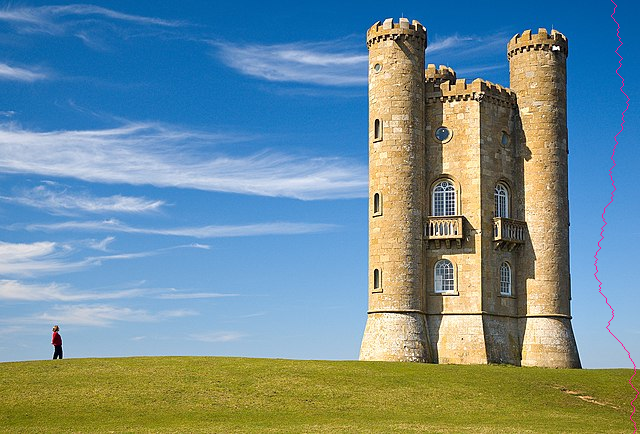

In [31]:
show_pnm('./before_0.pnm')

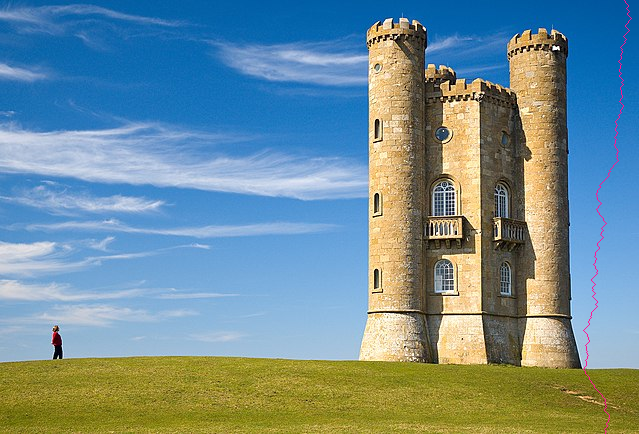

In [32]:
show_pnm('./before_1.pnm')

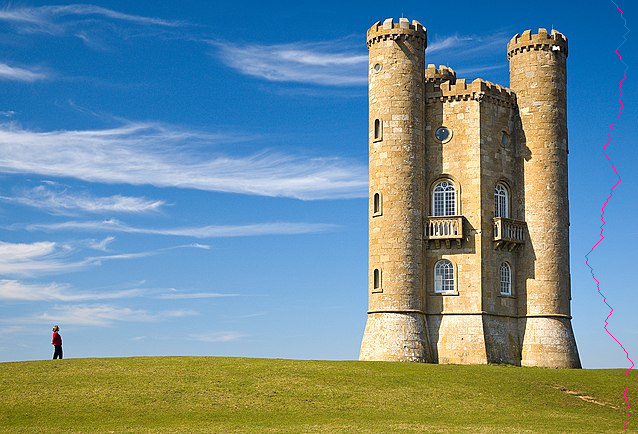

In [33]:
show_pnm('./before_2.pnm')

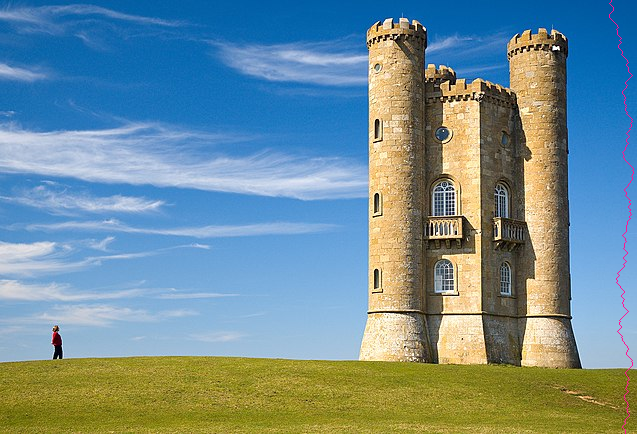

In [34]:
show_pnm('./before_3.pnm')

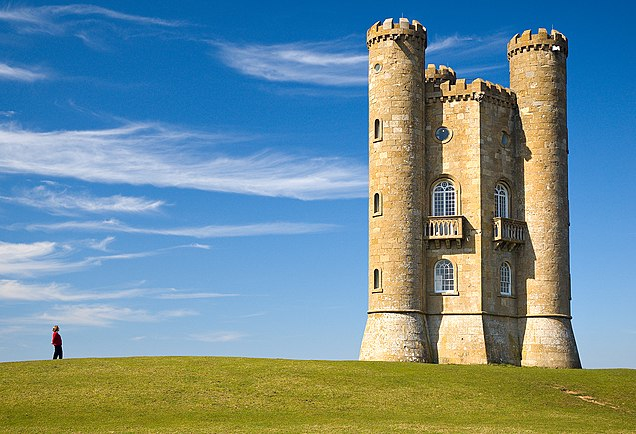

In [35]:
show_pnm('./seq_host.pnm')

## 2. Song song hoá Gray Scale

**Lý do:** Đây là phần tính toán dễ nhất do đã được thực hiện trong bài homework nên nhóm sẽ thực hiện lại để nhằm tối ưu hóa cho phần đồ án

**Kết quả** Ở phần dưới mình sẽ thấy được sau khi song song hóa phần GrayScale thì thời gian xử lý sẽ được giảm đi đáng kể với các phần thực hiện còn lại bằng tuần tự.

In [36]:
!nvcc -arch=sm_37 GrayScale.cu -o gs

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [37]:
!./gs in.pnm gray.pnm 2


Image size (width x height): 640 x 434
Processing time (use host): 98.170212 ms


Image size (width x height): 640 x 434
Block size (width x height): 32 x 32
Processing time (use device): 92.039742 ms

Gray Scale error: 0.000014
Seam Carving error: 0.000000

Image size after resize (width x height): 638 x 434


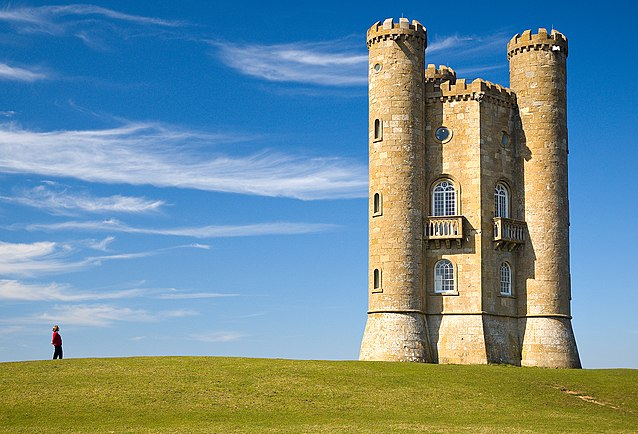

In [38]:
show_pnm('./gray_host.pnm')

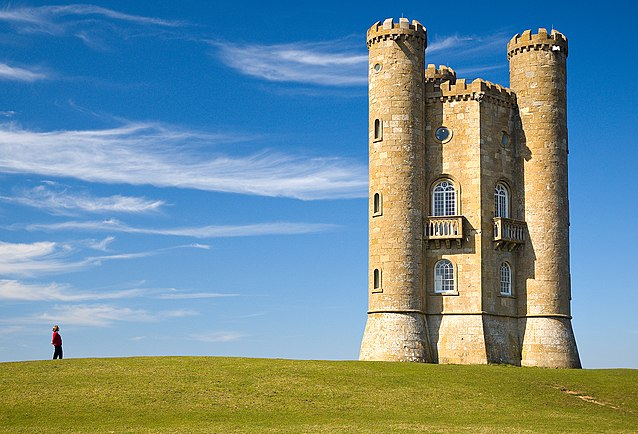

In [39]:
show_pnm('./gray_device.pnm')

## 3. Song song hoá phần tính Importance

**Lý do:** Đây là phần tính toán nhiều nhất trong quá trình seam carving vì từng pixel của bức ảnh sẽ phải nhân với *x-Sobel filter* và *y-Sobel filter* để có thể tính được độ quan trọng của pixel đó.

**Cách song song hoá:**
- Đối với *kernel 1*: Sử dụng GPU để tính độ quan trọng của pixel bằng các filter được khai báo trên Global Memory.
- Đối với *kernel 2*: Sử dụng GPU để tính độ quan trọng của pixel bằng các filter được khai báo trên Constant Memory.
- Đối với *kernel 3*: Sử dụng GPU để tính độ quan trọng của pixel được load vào Shared Memory bằng các filter được khai báo trên Constant Memory.

In [40]:
!nvcc -arch=sm_37 Importance.cu -o imp

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [41]:
!./imp in.pnm imp.pnm 2


Image size (width x height): 640 x 434
Processing time (use host): 100.292801 ms


Image size (width x height): 640 x 434


Using kernel 1... 
Processing time (use device): 16.285055 ms

Gray Scale error: 0.000014
Importance error: 0.988270
Seam Carving error: 0.717173

Image size (width x height): 640 x 434


Using kernel 2... 
Processing time (use device): 14.806080 ms

Gray Scale error: 0.000014
Importance error: 0.000090
Seam Carving error: 0.000000

Image size (width x height): 640 x 434


Using kernel 3... 
Processing time (use device): 14.810176 ms

Gray Scale error: 0.000014
Importance error: 0.006102
Seam Carving error: 0.000446

Image size after resize (width x height): 638 x 434


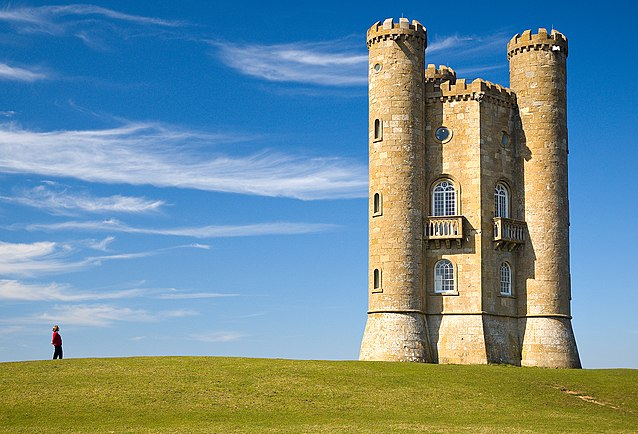

In [42]:
show_pnm('./imp_host.pnm')

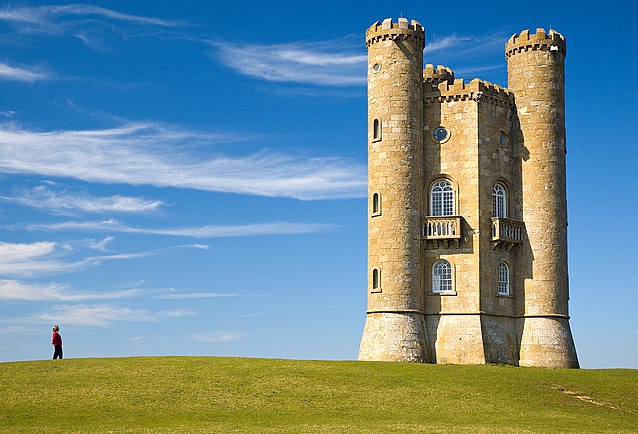

In [43]:
show_pnm('./imp_device1.pnm')

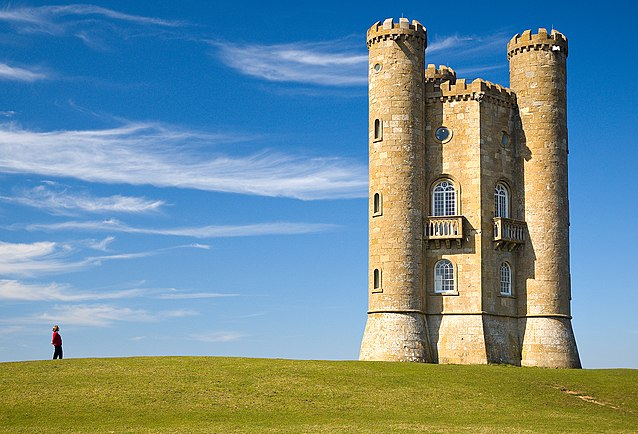

In [44]:
show_pnm('./imp_device2.pnm')

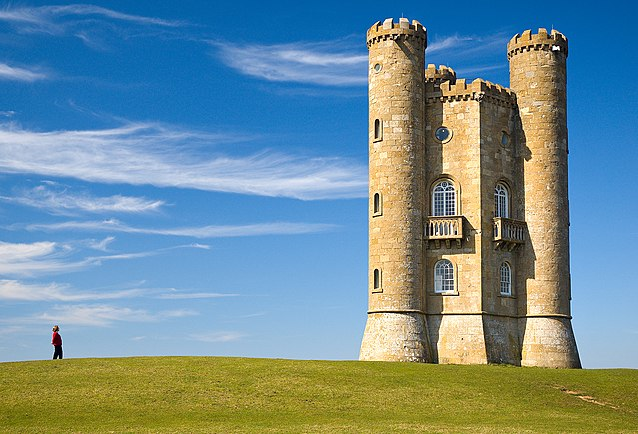

In [45]:
show_pnm('./imp_device3.pnm')

## 4. Song song hoá phần tìm đường đi của các seam

**Lý do:** Đây cũng là phần tính toán khá nhiều do phải duyệt qua hết bức ảnh để cho ra các seam, từ đó mới có thể chọn được seam có giá trị nhỏ nhất để loại bỏ.

**Cách song song hoá:**
- Sử dụng số lượng thread bằng với chiều rộng(width) của bước ảnh, sau đó duyệt hết bức ảnh theo từng dòng từ dưới lên để tạo ra các seam.

In [46]:
!nvcc -arch=sm_37 SC.cu -o sc

nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [47]:
!./sc in.pnm sc.pnm 2


Image size (width x height): 640 x 434
Processing time (use host): 101.331299 ms


Image size (width x height): 640 x 434
Block size (width x height): 32 x 32


Using kernel 2... 
Processing time (use device): 7.366144 ms

Gray Scale error: 0.000014
Importance error: 0.996137
Seam Carving error: 0.026656

Image size after resize (width x height): 638 x 434


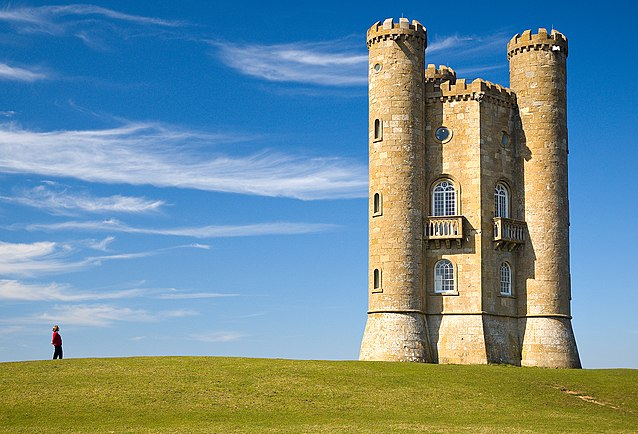

In [48]:
show_pnm('./sc_host.pnm')

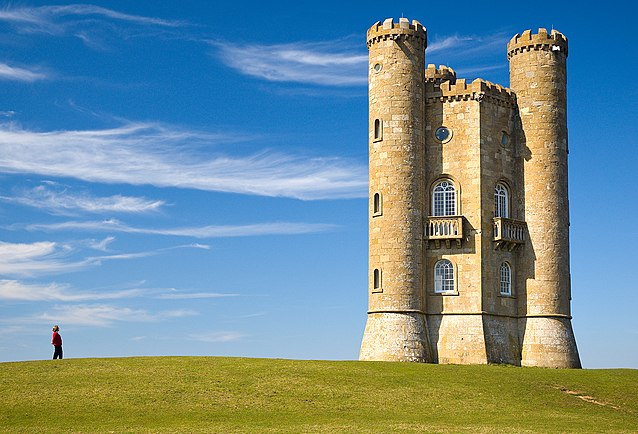

In [49]:
show_pnm('./sc_device1.pnm')

In [50]:
!./sc in.pnm out.pnm 400


Image size (width x height): 640 x 434
Processing time (use host): 12925.542969 ms


Image size (width x height): 640 x 434
Block size (width x height): 32 x 32


Using kernel 2... 
Processing time (use device): 806.872986 ms

Gray Scale error: 0.000014
Importance error: 0.890362
Seam Carving error: 0.944438

Image size after resize (width x height): 240 x 434


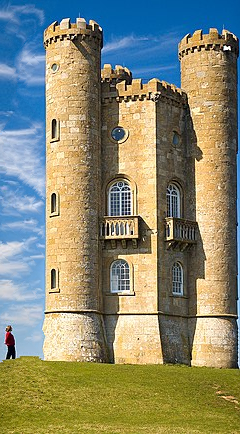

In [51]:
show_pnm('./out_host.pnm')

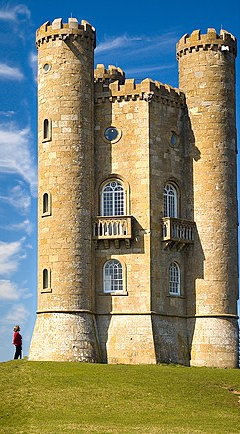

In [52]:
show_pnm('./out_device1.pnm')

## 5. Tự Đánh Giá
- **Võ Ngọc Minh**:
    - Khó khăn:
        - Trong quá trình code em hay gặp phải những lỗi do hàm chạy được ở C/C++ nhưng không chạy được trên GPU nên em phải tìm cách khác.
        - Cách suy nghĩ khi lập trình trên Shared memory hơi khác so với thông thường nên em bị mất thời gian ở phần đó khá nhiều.
    - Học được: 
        - Cách áp dụng song song hoá vào bài toán thực tế.
        - Hiểu thêm về lập trình song song trên GPU để tăng tốc độ chạy của chương trình, có thể ứng dụng vào các mô hình học máy trong tương lai.

- **Võ Văn Quốc Huy**:
    - Khó khăn:
        - Lúc bắt đầu đồ án thì cá nhân em khá mơ hồ vì chưa biết phải bắt đầu làm từ đâu và cần chuẩn bị hay sẽ làm gì thì nhờ teammate hướng dẫn thì em cũng nắm được và làm các phần được giao.
        - Ở phần lập trình tính giá trị quan trọng thì em hơi mông lung phần SMEM nên nhờ có hướng dẫn của bạn thì em cũng nắm được sơ bộ để hiểu.
    - Học được:
        - Áp dụng phần lập trình SMEM vào bài đồ án này.
        - Hiểu được mục đích môn học và áp dụng vào bài làm này mặc dù trong quá trình học không ít sự khó khăn khi tham gia buổi học với tình trạng mạng khu vực bị vấn đề.

- **Nếu có nhiều thời gian hơn**, team em sẽ có thể tối ưu phần tính Importance chạy bằng Shared memory vì tụi em nghĩ thời gian nó sẽ ngắn hơn nữa nếu được tối ưu đúng cách.



## 6. Tài liệu tham khảo

- https://pacman.cs.tsinghua.edu.cn/~cwg/papers_cwg/icpads14.pdf
- https://www.techiedelight.com/implement-itoa-function-in-c/
- https://en.wikipedia.org/wiki/Seam_carving

